In [6]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")
float_formatter = "{:.5}".format
np.set_printoptions(formatter={"float_kind": float_formatter})

In [7]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


query1 = """
    SELECT
        g.result,
        --.url,
        p.eval,
        p.ply,
        g.elo_white - g.elo_black as elo_dif
    FROM
        games g INNER JOIN positions p
        ON g.rowid = p.game_id
    WHERE
        g.result != 0
        AND p.eval is not NULL
    """

query2 = """
    SELECT 
        g.result,
        MIN(p.eval) as eval_min,
        MAX(p.eval) as eval_max
    FROM 
        games g INNER JOIN positions p 
        ON g.rowid = p.game_id
    WHERE
        g.result != 0
        AND p.eval is not NULL
        AND ABS(p.eval) < 9000
    GROUP BY g.url
    """
"""
    UNION
    SELECT 
        g.result,
        --MIN(p.eval) as eval_min
        MAX(p.eval) as eval_max
    FROM 
        games g INNER JOIN positions p 
        ON g.rowid = p.game_id
    WHERE
        g.result = -1
        AND p.eval is not NULL
    GROUP BY g.url
    """

with sqlite3.connect("games2.sqlite") as con:
    con.row_factory = dict_factory
    res = con.execute(query1)
    data = pd.DataFrame(res)

con.close()


<AxesSubplot: xlabel='ply', ylabel='eval'>

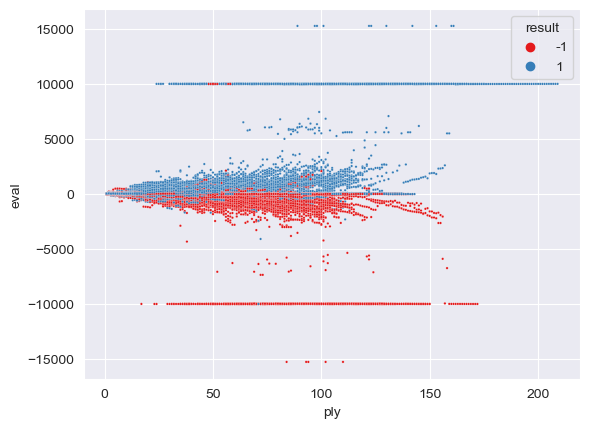

In [8]:
sns.scatterplot(
    data,
    x="ply",
    y="eval",
    hue="result",
    s=3,
    palette="Set1",
)


<AxesSubplot: xlabel='eval', ylabel='result'>

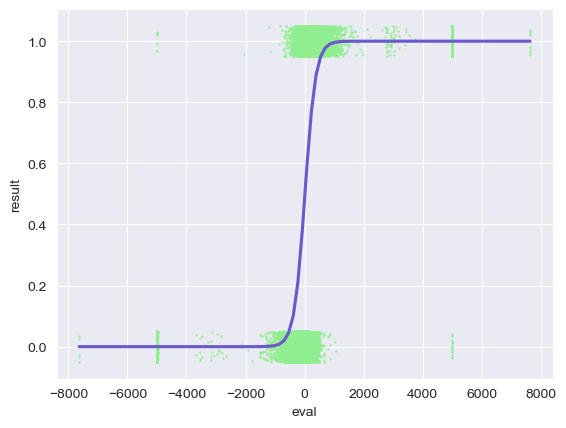

In [9]:
sns.regplot(
    data=(data + 1) / 2,
    x="eval",
    y="result",
    y_jitter=0.05,
    x_jitter=0.2,
    logistic=True,
    n_boot=1,
    ci=1,
    scatter_kws={"s": 0.5, "color": "lightgreen"},
    color="slateblue",
)


In [73]:
random_state = 42

features = [
    # "eval",
    # "url"
    # "ply",
    "elo_dif",
]
# features = ["eval_min"]

X = data[features]
y = data.result

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_state, stratify=y
)

scaler = StandardScaler()

classifier = LogisticRegressionCV(
    max_iter=50,
    Cs=11,
    random_state=random_state,
    n_jobs=-1,
    penalty="elasticnet",
    solver="saga",
    l1_ratios=np.linspace(0, 1, num=20),
    # class_weight="balanced",
)

model = Pipeline(
    steps=[
        ("scaler", scaler),
        ("classifier", classifier),
    ]
)


model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegressionCV(Cs=11,
                                      l1_ratios=array([0.0, 0.052632, 0.10526, 0.15789, 0.21053, 0.26316, 0.31579,
       0.36842, 0.42105, 0.47368, 0.52632, 0.57895, 0.63158, 0.68421,
       0.73684, 0.78947, 0.84211, 0.89474, 0.94737, 1.0]),
                                      max_iter=50, n_jobs=-1,
                                      penalty='elasticnet', random_state=42,
                                      solver='saga'))])

In [74]:
print(f"Accuracy: \n {model.score(X_test, y_test)}")
scale = model.named_steps["scaler"].scale_

coefs = model.named_steps["classifier"].coef_ / scale
print(f"Coefficients: \n {coefs}")

intercept = model.named_steps["classifier"].intercept_ / scale
print(f"Intercept: \n {intercept}")

cs = model.named_steps["classifier"].C_
print(f"Regularization strenght: \n {cs}")

l1_ratio = model.named_steps["classifier"].l1_ratio_

print(f"L1 Ratio: {l1_ratio}")

Accuracy: 
 0.6325862503147822
Coefficients: 
 [[0.0063217]]
Intercept: 
 [0.00043641]
Regularization strenght: 
 [0.025119]
L1 Ratio: [0.0]


In [75]:
print(f"Accuracy: \n {model.score(X_test, y_test)}")
scale = model.named_steps["scaler"].scale_

coefs = model.named_steps["classifier"].coef_ / scale
print(f"Coefficients: \n {coefs}")

intercept = model.named_steps["classifier"].intercept_ / scale
print(f"Intercept: \n {intercept}")

cs = model.named_steps["classifier"].C_
print(f"Regularization strenght: \n {cs}")

l1_ratio = model.named_steps["classifier"].l1_ratio_

print(f"L1 Ratio: {l1_ratio}")

Accuracy: 
 0.6325862503147822
Coefficients: 
 [[0.0063217]]
Intercept: 
 [0.00043641]
Regularization strenght: 
 [0.025119]
L1 Ratio: [0.0]


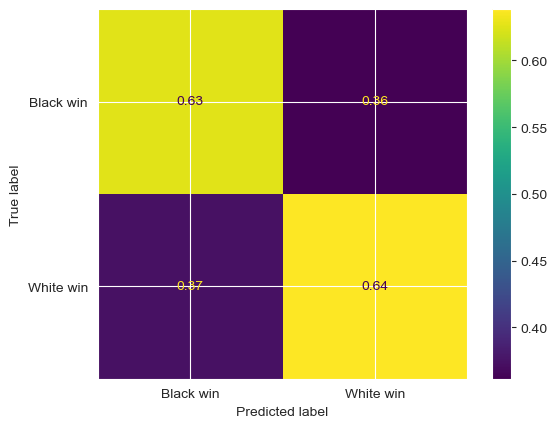

In [76]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    normalize="pred",
    display_labels=[
        "Black win",
        # "Draw",
        "White win",
    ],
)


In [77]:
test_positions = np.array([[-100, 100], [100, 0], [200, 10]])
model.predict_proba(test_positions)


c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 2 features, but StandardScaler is expecting 1 features as input.

In [86]:
model.predict_proba(np.arange(-200, 200))

c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[-200.0 -199.0 -198.0 -197.0 -196.0 -195.0 -194.0 -193.0 -192.0 -191.0
 -190.0 -189.0 -188.0 -187.0 -186.0 -185.0 -184.0 -183.0 -182.0 -181.0
 -180.0 -179.0 -178.0 -177.0 -176.0 -175.0 -174.0 -173.0 -172.0 -171.0
 -170.0 -169.0 -168.0 -167.0 -166.0 -165.0 -164.0 -163.0 -162.0 -161.0
 -160.0 -159.0 -158.0 -157.0 -156.0 -155.0 -154.0 -153.0 -152.0 -151.0
 -150.0 -149.0 -148.0 -147.0 -146.0 -145.0 -144.0 -143.0 -142.0 -141.0
 -140.0 -139.0 -138.0 -137.0 -136.0 -135.0 -134.0 -133.0 -132.0 -131.0
 -130.0 -129.0 -128.0 -127.0 -126.0 -125.0 -124.0 -123.0 -122.0 -121.0
 -120.0 -119.0 -118.0 -117.0 -116.0 -115.0 -114.0 -113.0 -112.0 -111.0
 -110.0 -109.0 -108.0 -107.0 -106.0 -105.0 -104.0 -103.0 -102.0 -101.0
 -100.0 -99.0 -98.0 -97.0 -96.0 -95.0 -94.0 -93.0 -92.0 -91.0 -90.0 -89.0
 -88.0 -87.0 -86.0 -85.0 -84.0 -83.0 -82.0 -81.0 -80.0 -79.0 -78.0 -77.0
 -76.0 -75.0 -74.0 -73.0 -72.0 -71.0 -70.0 -69.0 -68.0 -67.0 -66.0 -65.0
 -64.0 -63.0 -62.0 -61.0 -60.0 -59.0 -58.0 -57.0 -56.0 -55.0 -54.0 -53.0
 -52.0 -51.0 -50.0 -49.0 -48.0 -47.0 -46.0 -45.0 -44.0 -43.0 -42.0 -41.0
 -40.0 -39.0 -38.0 -37.0 -36.0 -35.0 -34.0 -33.0 -32.0 -31.0 -30.0 -29.0
 -28.0 -27.0 -26.0 -25.0 -24.0 -23.0 -22.0 -21.0 -20.0 -19.0 -18.0 -17.0
 -16.0 -15.0 -14.0 -13.0 -12.0 -11.0 -10.0 -9.0 -8.0 -7.0 -6.0 -5.0 -4.0
 -3.0 -2.0 -1.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0
 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0
 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0
 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0
 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0
 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0
 97.0 98.0 99.0 100.0 101.0 102.0 103.0 104.0 105.0 106.0 107.0 108.0
 109.0 110.0 111.0 112.0 113.0 114.0 115.0 116.0 117.0 118.0 119.0 120.0
 121.0 122.0 123.0 124.0 125.0 126.0 127.0 128.0 129.0 130.0 131.0 132.0
 133.0 134.0 135.0 136.0 137.0 138.0 139.0 140.0 141.0 142.0 143.0 144.0
 145.0 146.0 147.0 148.0 149.0 150.0 151.0 152.0 153.0 154.0 155.0 156.0
 157.0 158.0 159.0 160.0 161.0 162.0 163.0 164.0 165.0 166.0 167.0 168.0
 169.0 170.0 171.0 172.0 173.0 174.0 175.0 176.0 177.0 178.0 179.0 180.0
 181.0 182.0 183.0 184.0 185.0 186.0 187.0 188.0 189.0 190.0 191.0 192.0
 193.0 194.0 195.0 196.0 197.0 198.0 199.0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [87]:
(np.arange(-200, 200)[None]).shape

(1, 400)